# Probablistic model building genetic algorithm

In [1]:
%cd /mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn

/mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn


In [2]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()
from src.kinetic_model import KineticModel, modelSpace_to_modelParams, modelParams_to_modelSpace
from src.neural_network_builder import KineticEigenModelBuilder, KineticNeuralNetworkBuilder
from src.model_spaces import get_informed_deplete_ms as get_model_space
from src.neural_search import search_env, get_reward_pipeline
from src.data import get_sim_deplete_data as get_data
from src.reload import reload_from_dir

Using TensorFlow backend.


detected tf2 - using compatibility mode


In [3]:
import warnings
warnings.filterwarnings('ignore')
import time
from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

import scipy.stats as ss
import pandas as pd
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import shutil
import os
import pickle
import gc
from sklearn.model_selection import train_test_split

## Load data

In [4]:
data_fp = "data/sim_data/22-05-18_cas9_kinn_deplete_overlap/cas9_kinn_deplete_full_data.tsv"
param_fp = "data/sim_data/22-05-18_cas9_kinn_deplete_overlap/ka_params.yaml"
logbase = 10
(x_train, y_train), (x_test, y_test) = get_data(fp=data_fp, logbase=logbase)

(5000, 12)
(4613, 12)
0.9800041666377762 0.9998365927637564


## Setup AMBER

In [5]:
import amber
print(amber.__version__)
from amber.architect import pmbga
from amber.architect import ModelSpace, Operation

0.1.2


In [6]:
kinn_model_space = get_model_space(use_sink_state=False)
print(kinn_model_space)

StateSpace with 7 layers and 1 total combinations


In [7]:
controller = pmbga.ProbaModelBuildGeneticAlgo(
            model_space=kinn_model_space,
            buffer_type='population',
            buffer_size=50, # buffer size controlls the max history going back
            batch_size=1,   # batch size does not matter in this case; all arcs will be retrieved
            ewa_beta=0.9,  # ewa_beta approximates the moving average over 1/(1-ewa_beta) prev points
        )

## A For-Loop that does the work for `amber.architect.trainEnv`

In [8]:
wd = "outputs/notebook"
# trainEnv parameters
evo_params = dict(
    model_fn = KineticNeuralNetworkBuilder,
    samps_per_gen = 10,   # how many arcs to sample in each generation; important
    max_gen = 200,
    patience = 70,
    n_warmup_gen = 0,
    train_data = (x_train, y_train),
    test_data = (x_test, y_test)
)

# manager configs
# this learning rate is trickier than usual, for eigendecomp to work
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10*int(7000/128), # decrease every 10 epochs
    decay_rate=0.9,
    staircase=True)

if logbase is None:
    output_op = lambda: tf.keras.layers.Lambda(lambda x: x, name="output_nominal")
else:
    output_op = lambda: tf.keras.layers.Lambda(lambda x: tf.math.log(x)/np.log(logbase), name="output_log")

manager_kwargs={
    'optimizer': lambda: tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    'output_op': output_op,
    'n_feats': 50,
    'n_channels': 9,
    'batch_size': 128,
    'epochs': 100,
    'earlystop': 15,
    'verbose': 0
}

In [9]:
controller, hist, stat_df = search_env(
    controller=controller, 
    wd = wd,
    evo_params=evo_params, 
    manager_kwargs=manager_kwargs
)

datapoints:  5 / total:  10
[13:44:12] Gen 0 - Mean fitness 0.689 - Best 0.8860 - PostVar 5.756 - Time 71.60
datapoints:  9 / total:  20
[13:45:14] Gen 1 - Mean fitness 0.678 - Best 0.8860 - PostVar 5.822 - Time 62.50
datapoints:  15 / total:  30
[13:46:26] Gen 2 - Mean fitness 0.681 - Best 0.8978 - PostVar 5.528 - Time 72.08
datapoints:  21 / total:  40
[13:47:28] Gen 3 - Mean fitness 0.680 - Best 0.8978 - PostVar 5.728 - Time 62.00
datapoints:  27 / total:  50
[13:48:41] Gen 4 - Mean fitness 0.677 - Best 0.8978 - PostVar 5.559 - Time 72.19
datapoints:  35 / total:  60
[13:49:46] Gen 5 - Mean fitness 0.680 - Best 0.8978 - PostVar 5.637 - Time 65.14
datapoints:  40 / total:  70
[13:50:52] Gen 6 - Mean fitness 0.684 - Best 0.8978 - PostVar 5.540 - Time 66.56
datapoints:  45 / total:  80
[13:52:03] Gen 7 - Mean fitness 0.687 - Best 0.8978 - PostVar 5.435 - Time 70.86
datapoints:  49 / total:  90
[13:53:07] Gen 8 - Mean fitness 0.687 - Best 0.9589 - PostVar 5.584 - Time 63.74
datapoints: 

datapoints:  206 / total:  500
[15:14:11] Gen 73 - Mean fitness 0.860 - Best 0.9879 - PostVar 5.128 - Time 79.69
datapoints:  208 / total:  500
[15:15:21] Gen 74 - Mean fitness 0.860 - Best 0.9879 - PostVar 4.785 - Time 69.82
datapoints:  208 / total:  500
[15:16:33] Gen 75 - Mean fitness 0.862 - Best 0.9879 - PostVar 5.002 - Time 72.29
datapoints:  210 / total:  500
[15:17:44] Gen 76 - Mean fitness 0.864 - Best 0.9879 - PostVar 5.028 - Time 70.21
datapoints:  208 / total:  500
[15:18:54] Gen 77 - Mean fitness 0.869 - Best 0.9879 - PostVar 5.129 - Time 70.07
datapoints:  208 / total:  500
[15:20:06] Gen 78 - Mean fitness 0.871 - Best 0.9879 - PostVar 4.822 - Time 71.73
datapoints:  210 / total:  500
[15:21:21] Gen 79 - Mean fitness 0.871 - Best 0.9879 - PostVar 4.922 - Time 75.31
datapoints:  214 / total:  500
[15:22:35] Gen 80 - Mean fitness 0.873 - Best 0.9879 - PostVar 4.986 - Time 73.96
datapoints:  212 / total:  500
[15:23:50] Gen 81 - Mean fitness 0.877 - Best 0.9879 - PostVar 4.

datapoints:  308 / total:  500
[16:45:13] Gen 146 - Mean fitness 0.930 - Best 0.9908 - PostVar 3.961 - Time 70.77
datapoints:  332 / total:  500
[16:46:31] Gen 147 - Mean fitness 0.926 - Best 0.9908 - PostVar 3.902 - Time 78.61
datapoints:  329 / total:  500
[16:47:47] Gen 148 - Mean fitness 0.927 - Best 0.9908 - PostVar 3.888 - Time 75.95
datapoints:  321 / total:  500
[16:49:08] Gen 149 - Mean fitness 0.930 - Best 0.9908 - PostVar 4.121 - Time 80.47
datapoints:  305 / total:  500
[16:50:27] Gen 150 - Mean fitness 0.931 - Best 0.9908 - PostVar 4.289 - Time 79.38
datapoints:  296 / total:  500
[16:51:50] Gen 151 - Mean fitness 0.933 - Best 0.9908 - PostVar 4.361 - Time 82.72
datapoints:  326 / total:  500
[16:52:57] Gen 152 - Mean fitness 0.930 - Best 0.9908 - PostVar 4.154 - Time 66.66
datapoints:  309 / total:  500
[16:54:10] Gen 153 - Mean fitness 0.932 - Best 0.9908 - PostVar 4.213 - Time 73.34
datapoints:  340 / total:  500
[16:55:27] Gen 154 - Mean fitness 0.929 - Best 0.9908 - P

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


early-stop due to max patience w/o improvement


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


In [10]:
pd.DataFrame(hist).sort_values('test_reward', ascending=False).head()

,gen,arc,test_reward,rate_df
1059,105,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",0.990774,None
595,59,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",0.987917,None
1688,168,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",0.987816,None
1666,166,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",0.987737,None
783,78,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",0.987017,None


In [11]:
print("\n".join([str(x) 
                 for x in pd.DataFrame(hist).
                 sort_values('test_reward', ascending=False).
                 head(1)['arc'].values[0]]))

conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET': '1', 'kernel_size': 1, 'padding': 'same', 'EDGE': 1, 'RANGE_ST': 8, 'RANGE_D': 3}
conv1d:{'filters': 1, 'SOURCE': '1', 'TARGET': '0', 'kernel_size': 1, 'padding': 'same', 'EDGE': 1, 'RANGE_ST': 10, 'RANGE_D': 5}
conv1d:{'filters': 1, 'SOURCE': '1', 'TARGET': '2', 'kernel_size': 1, 'padding': 'same', 'EDGE': 1, 'RANGE_ST': 5, 'RANGE_D': 3}
conv1d:{'filters': 1, 'SOURCE': '2', 'TARGET': '1', 'kernel_size': 1, 'padding': 'same', 'EDGE': 1, 'RANGE_ST': 9, 'RANGE_D': 7}
conv1d:{'filters': 1, 'SOURCE': '2', 'TARGET': '3', 'kernel_size': 1, 'padding': 'same', 'EDGE': 1, 'RANGE_ST': 17, 'RANGE_D': 5}
conv1d:{'filters': 1, 'SOURCE': '3', 'TARGET': '2', 'kernel_size': 1, 'padding': 'same', 'EDGE': 1, 'RANGE_ST': 26, 'RANGE_D': 2}
conv1d:{'filters': 1, 'SOURCE': '3', 'TARGET': '0', 'kernel_size': 1, 'padding': 'same', 'EDGE': 1, 'RANGE_ST': 22, 'RANGE_D': 2, 'CONTRIB': 1}


In [12]:
a = pd.DataFrame(hist)
a['arc'] = ['|'.join([f"{x.Layer_attributes['RANGE_ST']}-{x.Layer_attributes['RANGE_ST']+x.Layer_attributes['RANGE_D']}" for x in entry]) for entry in a['arc']]
a.drop(columns=['rate_df'], inplace=True)
a.to_csv(os.path.join(wd,"train_history.tsv"), sep="\t", index=False)

Text(0.5, 0, 'Generation')

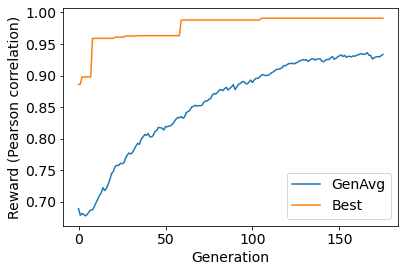

In [13]:
%matplotlib inline

ax = stat_df.plot.line(x='Generation', y=['GenAvg', 'Best'])
ax.set_ylabel("Reward (Pearson correlation)")
ax.set_xlabel("Generation")
#plt.savefig("reward_vs_time.png")

In [14]:
# ground truth
plot_gt = True
with open(param_fp, "r") as f:
    gt_model_params = yaml.load(f, Loader=yaml.Loader)
gt_model_params = modelParams_to_modelSpace(gt_model_params)
gt_rates = [k for k in gt_model_params['Rates']]

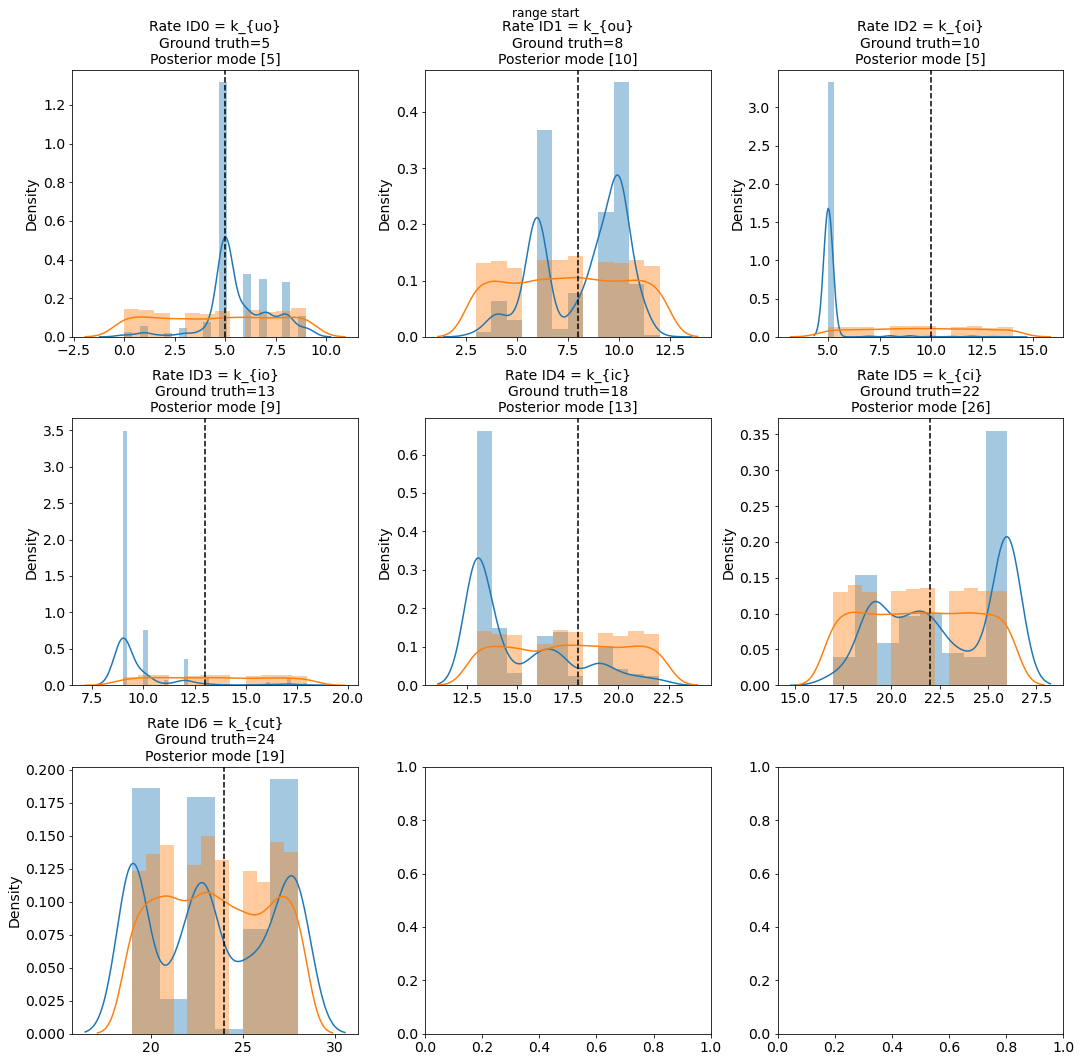

In [15]:
# START SITE
fig, axs_ = plt.subplots(3,3, figsize=(15,15))
axs = [axs_[i][j] for i in range(len(axs_)) for j in range(len(axs_[i]))]
for k in controller.model_space_probs:
    if k[-1] == 'RANGE_ST':
        try:
            d = controller.model_space_probs[k].sample(size=1000)
        except:
            continue
        ax = axs[k[0]]
        sns.distplot(d, label="Post", ax=ax)
        sns.distplot(controller.model_space_probs[k].prior_dist, label="Prior", ax=ax)
        if plot_gt:
            ax.axvline(gt_rates[k[0]]['RANGE_ST'], ls='--', color='black')
            ax.set_title(
                f'Rate ID{str(k[0])} = {gt_rates[k[0]]["name"]}\n'
                f'Ground truth={gt_rates[k[0]]["RANGE_ST"]}\nPosterior mode {str(ss.mode(d).mode)}')
        else:
            ax.set_title(
                f'Rate ID{str(k[0])} = {gt_rates[k[0]]["name"]}\n'
                f'Posterior mode {str(ss.mode(d).mode)}')
            

        #_ = ax.set_xlim(0,50)

fig.suptitle('range start')
fig.tight_layout()
#fig.savefig("range_st.png")

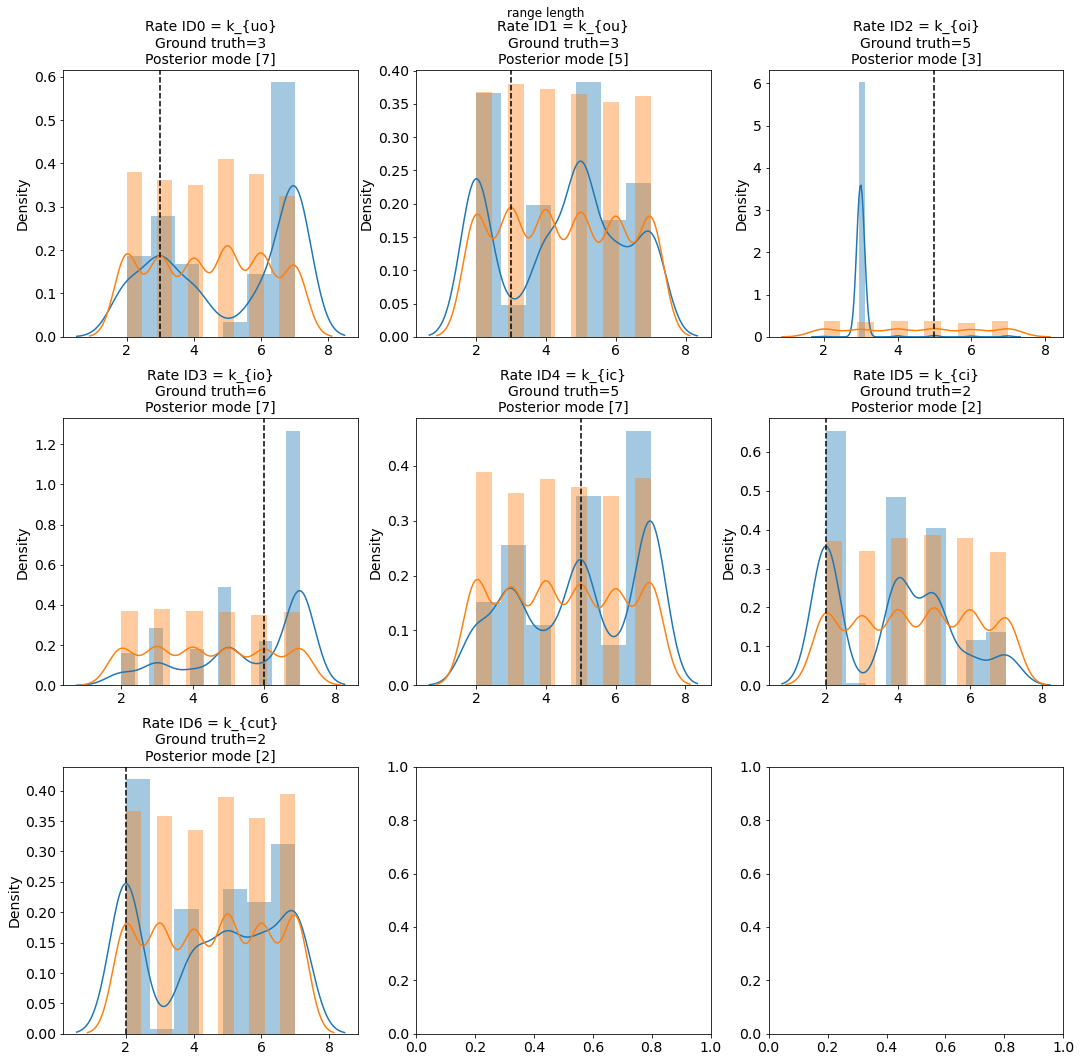

In [16]:
# CONV RANGE
fig, axs_ = plt.subplots(3,3, figsize=(15,15))
axs = [axs_[i][j] for i in range(len(axs_)) for j in range(len(axs_[i]))]
for k in controller.model_space_probs:
    if k[-1] == 'RANGE_D':
        d = controller.model_space_probs[k].sample(size=1000)
        ax = axs[k[0]]
        sns.distplot(d, ax=ax)
        sns.distplot(controller.model_space_probs[k].prior_dist, label="Prior", ax=ax)
        if plot_gt:
            ax.axvline(gt_rates[k[0]]['RANGE_D'], ls='--', color='black')
            ax.set_title(
                f'Rate ID{str(k[0])} = {gt_rates[k[0]]["name"]}\n'
                f'Ground truth={gt_rates[k[0]]["RANGE_D"]}\nPosterior mode {str(ss.mode(d).mode)}')
        else:
            ax.set_title(
                f'Rate ID{str(k[0])} = {gt_rates[k[0]]["name"]}\n'
                f'Posterior mode {str(ss.mode(d).mode)}')

fig.suptitle('range length')
fig.tight_layout()
#fig.savefig("range_d.png")

# KERNEL SIZE 
fig, axs_ = plt.subplots(3,3, figsize=(15,15))
axs = [axs_[i][j] for i in range(len(axs_)) for j in range(len(axs_[i]))]
for k in controller.model_space_probs:
    if k[-1] == 'kernel_size':
        d = controller.model_space_probs[k].sample(size=1000)
        ax = axs[k[0]]
        sns.distplot(d, ax=ax)
        sns.distplot(controller.model_space_probs[k].prior_dist, ax=ax)
        ax.set_title(
            ' '.join(['Rate ID', str(k[0]), '\nPosterior mean', str(np.mean(d))]))
        #_ = ax.set_xlim(0,20) 
fig.suptitle('kernel size')
fig.tight_layout()

pickle.load(open("outputs/notebook/AmberSearchBestModel_config.pkl", "rb"))

In [17]:
from src.neural_network_builder import KineticEigenModelBuilder, KineticNeuralNetworkBuilder
tf.compat.v1.reset_default_graph()
tf.compat.v1.experimental.output_all_intermediates(True)
sess = tf.compat.v1.Session()
mb = reload_from_dir(
    wd="outputs/notebook", 
    manager_kwargs=manager_kwargs,
    sess=sess,
    model_fn=KineticNeuralNetworkBuilder)
model = mb.model

loaded searched model


In [18]:
x_train_b = mb.blockify_seq_ohe(x_train)
x_test_b = mb.blockify_seq_ohe(x_test)

checkpointer = ModelCheckpoint(
    filepath=os.path.join(wd,"bestmodel.h5"), mode='min', verbose=0, save_best_only=True,
    save_weights_only=True)
earlystopper = EarlyStopping(
    monitor="val_loss",
    mode='min',
    patience=15,
    verbose=0)

model.fit(x_train_b, y_train,
          batch_size=128,
          validation_data=[x_test_b, y_test],
          callbacks=[checkpointer, earlystopper],
          epochs=225, 
          verbose=2)
model.load_weights(os.path.join(wd,"bestmodel.h5"))
y_hat = model.predict(x_test_b).flatten()
test_pcc = ss.pearsonr(y_hat, y_test)[0]

Train on 3690 samples, validate on 923 samples
Epoch 1/225
3690/3690 - 0s - loss: 0.0067 - val_loss: 0.0062
Epoch 2/225
3690/3690 - 0s - loss: 0.0055 - val_loss: 0.0053
Epoch 3/225
3690/3690 - 0s - loss: 0.0053 - val_loss: 0.0054
Epoch 4/225
3690/3690 - 0s - loss: 0.0053 - val_loss: 0.0055
Epoch 5/225
3690/3690 - 0s - loss: 0.0053 - val_loss: 0.0052
Epoch 6/225
3690/3690 - 0s - loss: 0.0054 - val_loss: 0.0054
Epoch 7/225
3690/3690 - 0s - loss: 0.0054 - val_loss: 0.0051
Epoch 8/225
3690/3690 - 0s - loss: 0.0053 - val_loss: 0.0052
Epoch 9/225
3690/3690 - 0s - loss: 0.0053 - val_loss: 0.0052
Epoch 10/225
3690/3690 - 0s - loss: 0.0053 - val_loss: 0.0055
Epoch 11/225
3690/3690 - 0s - loss: 0.0055 - val_loss: 0.0053
Epoch 12/225
3690/3690 - 0s - loss: 0.0053 - val_loss: 0.0052
Epoch 13/225
3690/3690 - 0s - loss: 0.0053 - val_loss: 0.0053
Epoch 14/225
3690/3690 - 0s - loss: 0.0055 - val_loss: 0.0054
Epoch 15/225
3690/3690 - 0s - loss: 0.0053 - val_loss: 0.0051
Epoch 16/225
3690/3690 - 0s - lo

In [19]:
[str(x.__dict__) for x in mb.kinn.rates]

["{'name': 'k_01', 'state_list': ['0', '1'], 'input_range': [8, 11], 'kernel_size': 1, 'scatter_nd': [((0, 0), -1), ((1, 0), 1)], 'filters': 1, 'SOURCE': '0', 'TARGET': '1', 'padding': 'same', 'EDGE': 1, 'RANGE_ST': 8, 'RANGE_D': 3, 'template': None}",
 "{'name': 'k_10', 'state_list': ['1', '0'], 'input_range': [10, 15], 'kernel_size': 1, 'scatter_nd': [((1, 1), -1), ((0, 1), 1)], 'filters': 1, 'SOURCE': '1', 'TARGET': '0', 'padding': 'same', 'EDGE': 1, 'RANGE_ST': 10, 'RANGE_D': 5, 'template': None}",
 "{'name': 'k_12', 'state_list': ['1', '2'], 'input_range': [5, 8], 'kernel_size': 1, 'scatter_nd': [((1, 1), -1), ((2, 1), 1)], 'filters': 1, 'SOURCE': '1', 'TARGET': '2', 'padding': 'same', 'EDGE': 1, 'RANGE_ST': 5, 'RANGE_D': 3, 'template': None}",
 "{'name': 'k_21', 'state_list': ['2', '1'], 'input_range': [9, 16], 'kernel_size': 1, 'scatter_nd': [((2, 2), -1), ((1, 2), 1)], 'filters': 1, 'SOURCE': '2', 'TARGET': '1', 'padding': 'same', 'EDGE': 1, 'RANGE_ST': 9, 'RANGE_D': 7, 'templa

In [20]:
layer_dict = {l.name:l for l in model.layers}

In [21]:
np.around(layer_dict['conv_k0'].get_weights()[0],3)

array([[[-2.156],
        [-2.141],
        [-2.094],
        [-2.082],
        [ 0.   ],
        [ 0.   ],
        [ 0.   ],
        [ 0.   ],
        [ 0.   ]]], dtype=float32)

In [22]:
np.around(layer_dict['conv_k1'].get_weights()[0],3)

array([[[2.942],
        [2.965],
        [3.036],
        [2.98 ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ]]], dtype=float32)

spearman SpearmanrResult(correlation=0.7910051408054536, pvalue=9.880269668521248e-199)
pearson (0.991155396436507, 0.0)


Text(0.5, 0.98, 'Testing prediction, pcc=0.991')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


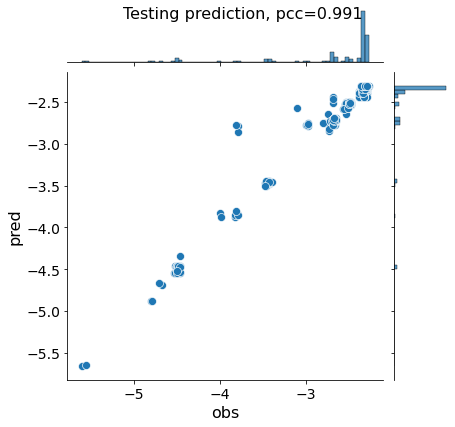

In [23]:
x_test_b = mb.blockify_seq_ohe(x_test)
y_hat = model.predict(x_test_b).flatten()
h = sns.jointplot(y_test, y_hat)
h.set_axis_labels("obs", "pred", fontsize=16)
print("spearman", ss.spearmanr(y_hat, y_test))
p = ss.pearsonr(y_hat, y_test)
print("pearson", p)
h.fig.suptitle("Testing prediction, pcc=%.3f"%p[0], fontsize=16)